<a href="https://colab.research.google.com/github/mforker/kaggle/blob/main/kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(df.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [ ]:
print(df.shape)
print(df_test.shape)

(750000, 12)
(250000, 11)


In [ ]:
df = df.drop_duplicates()
df_test = df_test.drop_duplicates()
print(df.shape)
print(df_test.shape)

(750000, 12)
(250000, 11)


In [ ]:
print('--------------train data----------')
print(df.isna().sum())
print('--------------test data------------')
print(df_test.isna().sum())

--------------train data----------
id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64
--------------test data------------
id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64


In [ ]:
df = df[~df['Number_of_Ads'].isna()]
print('train data shape:',df.shape)

df_test = df_test[~df_test['Number_of_Ads'].isna()]
print('test data shape:',df_test.shape)

train data shape: (749999, 12)
test data shape: (250000, 11)


In [ ]:
# # rough
# for col in df_test.columns:
#     if df_test[col].dtype == 'int' or df_test[col].dtype == 'float':
#       sns.boxplot(x = df_test[col])
#       plt.xlabel(col)
#       plt.title(f'Boxplot of test_data:{col}')
#       plt.show()
#

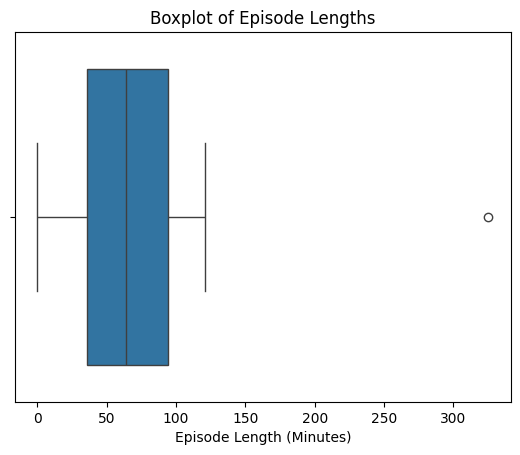

In [ ]:
#plotting outliers for train data
sns.boxplot(x = df['Episode_Length_minutes'])
plt.xlabel('Episode Length (Minutes)')
plt.title('Boxplot of Episode Lengths')
plt.show()

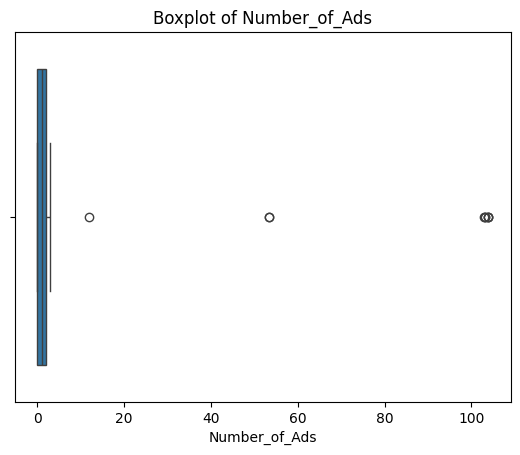

In [ ]:
#plotting outliers for train data
sns.boxplot(x = df['Number_of_Ads'])
plt.xlabel('Number_of_Ads')
plt.title('Boxplot of Number_of_Ads')
plt.show()

In [ ]:
# removing outliers for train data
q1 = df['Episode_Length_minutes'].quantile(0.25)
q3 = df['Episode_Length_minutes'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_nan = df[df['Episode_Length_minutes'].isna()]
df = df[~df['Episode_Length_minutes'].isna()]
df = df[(df['Episode_Length_minutes'] >= lower_bound) & (df['Episode_Length_minutes'] <= upper_bound)]
df = pd.concat([df,df_nan])
print(df.shape)

(749998, 12)


In [ ]:
# removing outliers for train data
q1 = df['Number_of_Ads'].quantile(0.25)
q3 = df['Number_of_Ads'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_nan = df[df['Number_of_Ads'].isna()]
df = df[~df['Number_of_Ads'].isna()]
df = df[(df['Number_of_Ads'] >= lower_bound) & (df['Number_of_Ads'] <= upper_bound)]
df = pd.concat([df,df_nan])
print(df.shape)

(749989, 12)


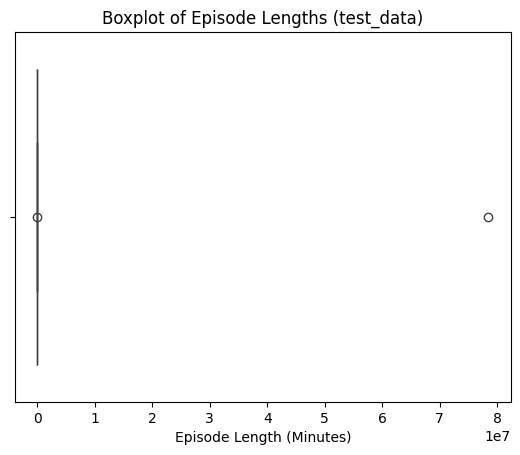

In [ ]:
#plotting outliers for train data
sns.boxplot(x = df_test['Episode_Length_minutes'])
plt.xlabel('Episode Length (Minutes)')
plt.title('Boxplot of Episode Lengths (test_data)')
plt.show()

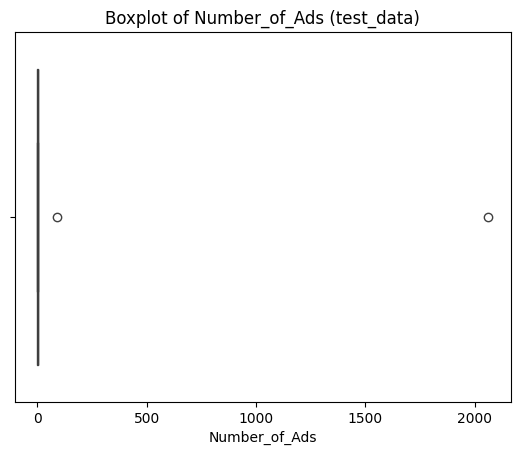

In [ ]:
#plotting outliers for train data
sns.boxplot(x = df_test['Number_of_Ads'])
plt.xlabel('Number_of_Ads')
plt.title('Boxplot of Number_of_Ads (test_data)')
plt.show()

In [ ]:
# removing outliers for test data
q1 = df_test['Episode_Length_minutes'].quantile(0.25)
q3 = df_test['Episode_Length_minutes'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_test_nan = df_test[df_test['Episode_Length_minutes'].isna()]
df_test = df_test[~df_test['Episode_Length_minutes'].isna()]
df_test = df_test[(df_test['Episode_Length_minutes'] >= lower_bound) & (df_test['Episode_Length_minutes'] <= upper_bound)]
df_test = pd.concat([df_test,df_test_nan])
print(df_test.shape)

(249998, 11)


In [ ]:
# removing outliers for test data
q1 = df_test['Number_of_Ads'].quantile(0.25)
q3 = df_test['Number_of_Ads'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_test_nan = df_test[df_test['Number_of_Ads'].isna()]
df_test = df_test[~df_test['Number_of_Ads'].isna()]
df_test = df_test[(df_test['Number_of_Ads'] >= lower_bound) & (df_test['Number_of_Ads'] <= upper_bound)]
df_test = pd.concat([df_test,df_test_nan])
print(df_test.shape)

(249996, 11)


In [ ]:
# imputing Episode Length Minutes train data
mean_len = df.groupby('Podcast_Name')['Episode_Length_minutes'].mean().reset_index(name = 'Mean_Dur')
mean_len_map = mean_len.set_index('Podcast_Name')['Mean_Dur'].to_dict()
mean_len_map


{"Athlete's Arena": 65.84145002666152,
 'Brain Boost': 63.45841916371799,
 'Business Briefs': 66.67273117600233,
 'Business Insights': 62.85052578646617,
 'Comedy Corner': 62.63415984873937,
 'Crime Chronicles': 66.09306282286539,
 'Criminal Minds': 61.44970857441532,
 'Current Affairs': 62.01022120059374,
 'Daily Digest': 65.28976221517944,
 'Detective Diaries': 65.83168232027475,
 'Digital Digest': 63.4173656755638,
 'Educational Nuggets': 65.06675002035371,
 'Fashion Forward': 64.62641731163349,
 'Finance Focus': 62.0513269868116,
 'Fitness First': 65.38452896585173,
 'Funny Folks': 63.73354234956822,
 'Gadget Geek': 65.03048366346326,
 'Game Day': 62.7135723936742,
 'Global News': 65.77577336517001,
 'Health Hour': 64.41884199562652,
 'Healthy Living': 64.53538735710995,
 'Home & Living': 66.50949387549903,
 'Humor Hub': 65.41717706239568,
 'Innovators': 64.52611539726462,
 'Joke Junction': 61.348252092201896,
 'Laugh Line': 63.03206505745214,
 'Learning Lab': 65.2761204178481,
 'L

In [ ]:
# imputing Guest_Popularity_percentage train data
pop_rating_gener = df.groupby('Genre')['Guest_Popularity_percentage'].mean().reset_index(name = 'Mean_Pop')
rating_map = pop_rating_gener.set_index('Genre')['Mean_Pop'].to_dict()
rating_map

{'Business': 51.22199563894205,
 'Comedy': 53.36126372340106,
 'Education': 52.3152052570545,
 'Health': 51.441465000343804,
 'Lifestyle': 51.757591048236094,
 'Music': 52.054404132064754,
 'News': 52.43683772161711,
 'Sports': 53.077234609328485,
 'Technology': 51.83673721373768,
 'True Crime': 52.714811690746025}

In [ ]:
df.loc[df['Guest_Popularity_percentage'].isna(),'Guest_Popularity_percentage'] = (df.loc[df['Guest_Popularity_percentage'].isna(),'Genre'].map(rating_map))
print(df.isna().sum())

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         87093
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage        0
Number_of_Ads                      0
Episode_Sentiment                  0
Listening_Time_minutes             0
dtype: int64


In [ ]:
df.loc[df['Episode_Length_minutes'].isna(),'Episode_Length_minutes'] = (df.loc[df['Episode_Length_minutes'].isna(),'Podcast_Name'].map(mean_len_map))
print(df.isna().sum())
df.loc[df['Podcast_Name']=='Music Matters',:]

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
38,38,Music Matters,Episode 32,86.840000,Music,86.65,Thursday,Morning,28.270000,1.0,Neutral,81.49839
64,64,Music Matters,Episode 69,81.130000,Music,66.37,Wednesday,Evening,97.430000,1.0,Negative,55.97010
85,85,Music Matters,Episode 23,9.730000,Music,31.68,Tuesday,Morning,52.060000,1.0,Neutral,6.01368
127,127,Music Matters,Episode 59,64.570000,Music,84.75,Thursday,Morning,52.054404,1.0,Neutral,53.49181
209,209,Music Matters,Episode 21,85.180000,Music,85.61,Wednesday,Evening,96.450000,1.0,Neutral,73.71758
...,...,...,...,...,...,...,...,...,...,...,...,...
745564,745564,Music Matters,Episode 45,65.192867,Music,71.76,Tuesday,Night,33.560000,2.0,Negative,97.47198
745642,745642,Music Matters,Episode 69,65.192867,Music,23.22,Sunday,Afternoon,18.900000,0.0,Negative,66.61818
748086,748086,Music Matters,Episode 85,65.192867,Music,41.10,Saturday,Afternoon,79.400000,0.0,Positive,91.31101
749364,749364,Music Matters,Episode 34,65.192867,Music,76.19,Friday,Morning,99.080000,3.0,Positive,51.55510


In [ ]:
# imputing Episode Length Minutes test data
test_mean_len = df_test.groupby('Podcast_Name')['Episode_Length_minutes'].mean().reset_index(name = 'Mean_Dur')
test_mean_len_map = test_mean_len.set_index('Podcast_Name')['Mean_Dur'].to_dict()
test_mean_len_map

{"Athlete's Arena": 65.12400223990402,
 'Brain Boost': 63.55702779197694,
 'Business Briefs': 66.73816472337504,
 'Business Insights': 62.53988221420274,
 'Comedy Corner': 63.11928717586774,
 'Crime Chronicles': 65.9042661971855,
 'Criminal Minds': 61.119463578531416,
 'Current Affairs': 62.19247706330044,
 'Daily Digest': 65.47994189256232,
 'Detective Diaries': 66.18937561614567,
 'Digital Digest': 62.77205851416113,
 'Educational Nuggets': 64.17391255298105,
 'Fashion Forward': 64.35771060252483,
 'Finance Focus': 62.35637068779561,
 'Fitness First': 66.1003914756141,
 'Funny Folks': 63.6383543978125,
 'Gadget Geek': 64.93357723912322,
 'Game Day': 62.70095211626103,
 'Global News': 65.58818986538334,
 'Health Hour': 63.28424440501039,
 'Healthy Living': 65.03355382776243,
 'Home & Living': 66.23382526629666,
 'Humor Hub': 65.92613874577283,
 'Innovators': 66.35921274283481,
 'Joke Junction': 61.4982957730889,
 'Laugh Line': 63.28202952327669,
 'Learning Lab': 65.86662320897504,
 'L

In [ ]:
# imputing Guest_Popularity_percentage test data
test_pop_rating_gener = df_test.groupby('Genre')['Guest_Popularity_percentage'].mean().reset_index(name = 'Mean_Pop')
test_rating_map = test_pop_rating_gener.set_index('Genre')['Mean_Pop'].to_dict()
test_rating_map

{'Business': 51.377071085996484,
 'Comedy': 53.15304508484497,
 'Education': 52.10616224529027,
 'Health': 51.406536136187775,
 'Lifestyle': 52.06262862694873,
 'Music': 51.90412944073162,
 'News': 52.46579460801703,
 'Sports': 53.058590066426426,
 'Technology': 51.55995068396122,
 'True Crime': 52.61235182058276}

In [ ]:
df_test.loc[df_test['Guest_Popularity_percentage'].isna(),'Guest_Popularity_percentage'] = (df_test.loc[df_test['Guest_Popularity_percentage'].isna(),'Genre'].map(test_rating_map))
print(df_test.isna().sum())

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage        0
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64


In [ ]:
df_test.loc[df_test['Episode_Length_minutes'].isna(),'Episode_Length_minutes'] = (df_test.loc[df_test['Episode_Length_minutes'].isna(),'Podcast_Name'].map(test_mean_len_map))
print(df_test.isna().sum())
df_test.loc[df_test['Podcast_Name']=='Music Matters',:]

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
88,750088,Music Matters,Episode 25,20.32000,Music,94.12,Thursday,Evening,51.904129,2.0,Positive
119,750119,Music Matters,Episode 75,34.97000,Music,84.58,Tuesday,Morning,92.240000,1.0,Positive
149,750149,Music Matters,Episode 38,12.87000,Music,28.38,Monday,Evening,66.930000,0.0,Neutral
154,750154,Music Matters,Episode 33,78.22000,Music,88.07,Tuesday,Night,51.904129,1.0,Negative
168,750168,Music Matters,Episode 75,72.02000,Music,96.93,Thursday,Afternoon,82.410000,0.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
249331,999331,Music Matters,Episode 69,64.84329,Music,26.40,Friday,Afternoon,26.690000,0.0,Negative
249672,999672,Music Matters,Episode 88,64.84329,Music,28.96,Friday,Night,86.360000,0.0,Negative
249718,999718,Music Matters,Episode 49,64.84329,Music,42.85,Friday,Afternoon,51.904129,3.0,Negative
249877,999877,Music Matters,Episode 69,64.84329,Music,98.26,Monday,Morning,34.520000,2.0,Negative


In [ ]:
cols = list(df.columns)
cols.remove('Episode_Title')
cols.remove('id')
df = df.loc[:,cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749989 entries, 1 to 749984
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 749989 non-null  object 
 1   Episode_Length_minutes       749989 non-null  float64
 2   Genre                        749989 non-null  object 
 3   Host_Popularity_percentage   749989 non-null  float64
 4   Publication_Day              749989 non-null  object 
 5   Publication_Time             749989 non-null  object 
 6   Guest_Popularity_percentage  749989 non-null  float64
 7   Number_of_Ads                749989 non-null  float64
 8   Episode_Sentiment            749989 non-null  object 
 9   Listening_Time_minutes       749989 non-null  float64
dtypes: float64(5), object(5)
memory usage: 62.9+ MB


In [ ]:
cols = list(df_test.columns)
cols.remove('Episode_Title')
cols.remove('id')
df_test = df_test.loc[:,cols]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249996 entries, 0 to 249982
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 249996 non-null  object 
 1   Episode_Length_minutes       249996 non-null  float64
 2   Genre                        249996 non-null  object 
 3   Host_Popularity_percentage   249996 non-null  float64
 4   Publication_Day              249996 non-null  object 
 5   Publication_Time             249996 non-null  object 
 6   Guest_Popularity_percentage  249996 non-null  float64
 7   Number_of_Ads                249996 non-null  float64
 8   Episode_Sentiment            249996 non-null  object 
dtypes: float64(4), object(5)
memory usage: 19.1+ MB


In [ ]:
encoder = LabelEncoder()
df.loc[:,'Genre'] = encoder.fit_transform(df.loc[:,'Genre'])
df.loc[:,'Podcast_Name'] = encoder.fit_transform(df.loc[:,'Podcast_Name'])
df.loc[:,'Publication_Day'] = encoder.fit_transform(df.loc[:,'Publication_Day'])
df.loc[:,'Publication_Time'] = encoder.fit_transform(df.loc[:,'Publication_Time'])
df.loc[:,'Episode_Sentiment'] = encoder.fit_transform(df.loc[:,'Episode_Sentiment'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749989 entries, 1 to 749984
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 749989 non-null  object 
 1   Episode_Length_minutes       749989 non-null  float64
 2   Genre                        749989 non-null  object 
 3   Host_Popularity_percentage   749989 non-null  float64
 4   Publication_Day              749989 non-null  object 
 5   Publication_Time             749989 non-null  object 
 6   Guest_Popularity_percentage  749989 non-null  float64
 7   Number_of_Ads                749989 non-null  float64
 8   Episode_Sentiment            749989 non-null  object 
 9   Listening_Time_minutes       749989 non-null  float64
dtypes: float64(5), object(5)
memory usage: 62.9+ MB


In [ ]:
df_test.loc[:,'Genre'] = encoder.fit_transform(df_test.loc[:,'Genre'])
df_test.loc[:,'Podcast_Name'] = encoder.fit_transform(df_test.loc[:,'Podcast_Name'])
df_test.loc[:,'Publication_Day'] = encoder.fit_transform(df_test.loc[:,'Publication_Day'])
df_test.loc[:,'Publication_Time'] = encoder.fit_transform(df_test.loc[:,'Publication_Time'])
df_test.loc[:,'Episode_Sentiment'] = encoder.fit_transform(df_test.loc[:,'Episode_Sentiment'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249996 entries, 0 to 249982
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 249996 non-null  object 
 1   Episode_Length_minutes       249996 non-null  float64
 2   Genre                        249996 non-null  object 
 3   Host_Popularity_percentage   249996 non-null  float64
 4   Publication_Day              249996 non-null  object 
 5   Publication_Time             249996 non-null  object 
 6   Guest_Popularity_percentage  249996 non-null  float64
 7   Number_of_Ads                249996 non-null  float64
 8   Episode_Sentiment            249996 non-null  object 
dtypes: float64(4), object(5)
memory usage: 19.1+ MB


In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749989 entries, 1 to 749984
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 749989 non-null  int64  
 1   Episode_Length_minutes       749989 non-null  float64
 2   Genre                        749989 non-null  int64  
 3   Host_Popularity_percentage   749989 non-null  float64
 4   Publication_Day              749989 non-null  int64  
 5   Publication_Time             749989 non-null  int64  
 6   Guest_Popularity_percentage  749989 non-null  float64
 7   Number_of_Ads                749989 non-null  float64
 8   Episode_Sentiment            749989 non-null  int64  
 9   Listening_Time_minutes       749989 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 62.9 MB


In [ ]:
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        df_test[col] = df_test[col].astype('int')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249996 entries, 0 to 249982
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 249996 non-null  int64  
 1   Episode_Length_minutes       249996 non-null  float64
 2   Genre                        249996 non-null  int64  
 3   Host_Popularity_percentage   249996 non-null  float64
 4   Publication_Day              249996 non-null  int64  
 5   Publication_Time             249996 non-null  int64  
 6   Guest_Popularity_percentage  249996 non-null  float64
 7   Number_of_Ads                249996 non-null  float64
 8   Episode_Sentiment            249996 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 19.1 MB


### training and testing on train data

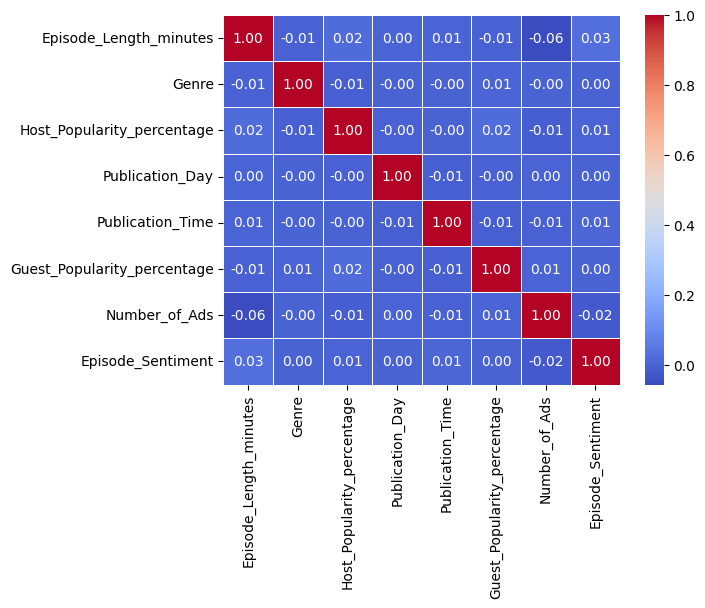

In [ ]:
features, target = df.drop(['Listening_Time_minutes','Podcast_Name'], axis=1), df['Listening_Time_minutes']
cm = features.corr()
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [ ]:
features, target = df.drop(['Listening_Time_minutes','Podcast_Name'], axis=1), df['Listening_Time_minutes']
# features = MinMaxScaler().fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

Root Mean Squared Error: 13.03
